# Boletín 4 - Neural Networks

### Importar las librerías y fijar la semilla

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  # Para evitar warnings en algunas gráficas

In [3]:
SEED_VALUE = 1

## Ejercicio 2: Clasificación - Blood Transfusion Service Center


In [5]:
DATASET_NAME = 'bloodTransfusion.data'
DATASET_DELIMITER = ','

### Leemos el fichero de datos

In [6]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1,
                      header=None,
                      names = ["Recency", "Frequency", "Monetary", "Time", "MarchDonor"])
dataset

,Recency,Frequency,Monetary,Time,MarchDonor
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
5,4,4,1000,4,0
6,2,7,1750,14,1
7,1,12,3000,35,0
8,2,9,2250,22,1
9,5,46,11500,98,1


El fichero contiene 5 variables y 748 observaciones. Las variables predictoras son `Recency`, `Frequency`, `Monetary`, `Time`, y la variable dependiente sería `MarchDonor`. Es una clasificación binaria - existen 2 clases `0`(no ha donado sangre) y  `1` (ha donado sangre).

## Visualizamos los datos

Visualizamos la distribución de variables por clases.

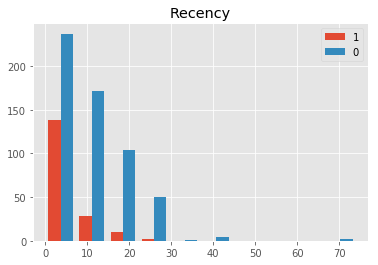

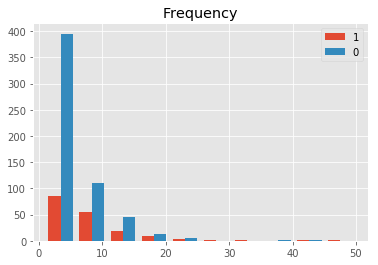

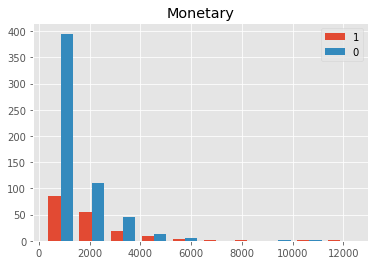

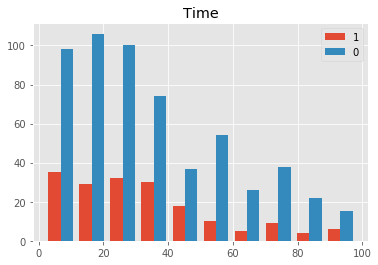

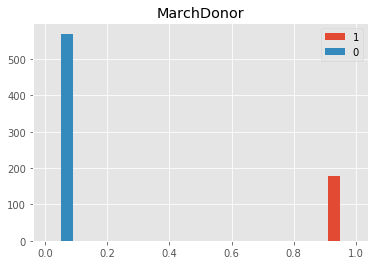

In [7]:
for column in dataset:  
    plt.title(column)
    plt.hist([dataset[dataset['MarchDonor'] == 1][column], dataset[dataset['MarchDonor'] == 0][column]], label=['1', '0'])
    plt.legend(loc='upper right')
    plt.show()

Visualizar los datos y sus clases por pares de atributos mostrando también la clase con color.

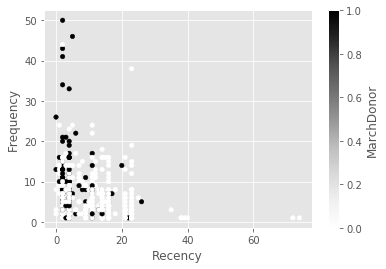

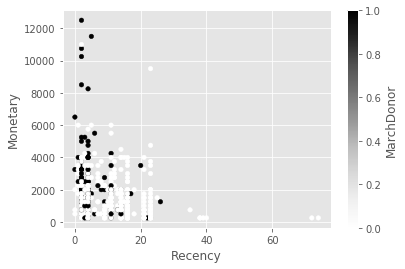

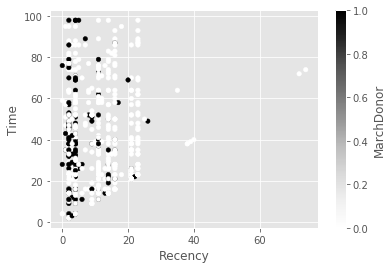

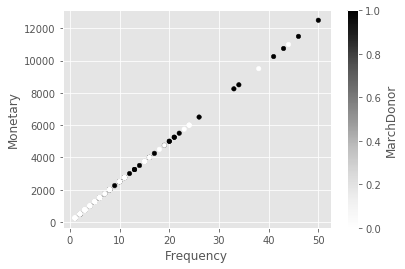

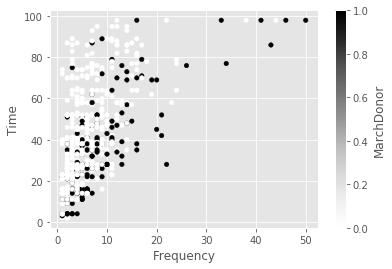

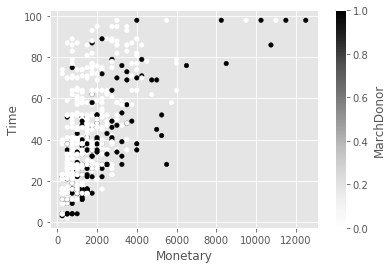

In [8]:
column_names = dataset.columns[:-1]  
for i, columna_i in enumerate(column_names):
    for j, columna_j in enumerate(column_names):
        if i < j:
            fig, ax = plt.subplots()
            dataset.plot.scatter(columna_i, columna_j, c='MarchDonor', ax=ax)

Se ve que hay correlación entre las variables Frequency que representa el número total de donaciones y Monetary - la cantidad total de la sagre donada. Esto tiene sentido. Sin embargo, cuando usamos KNN la correlación entre variables no afecta el modelo por esto trabajaremos con todas las variables de entrada.

### División de los datos en entrenamiento (80%) y test (20%)

Dividimos los datos en entrenamiento y test usando la samilla y estratificamos por la variable de salida MarchDonor para mantener la misma proporción en el conjunto de entrenamiento y en el conjunto de test.

In [9]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE, stratify=dataset["MarchDonor"])
dataset_test

,Recency,Frequency,Monetary,Time,MarchDonor
309,16,3,750,19,0
711,23,6,1500,45,0
343,11,1,250,11,0
462,21,1,250,21,1
646,14,2,500,14,0
722,21,3,750,40,0
740,23,1,250,23,0
568,4,6,1500,35,1
539,2,2,500,4,1
244,9,2,500,11,0


### Separación de variables predictoras y dependientes

Separamos los conjutos de test creando un dataframe para las variables de entrada y un para la de salida.

In [10]:
dataset_train_X = dataset_train.loc[:, "Recency":"Time"].astype(float)
dataset_train_Y = dataset_train.loc[:, "MarchDonor"]

dataset_test_X = dataset_test.loc[:, "Recency":"Time"].astype(float)
dataset_test_Y = dataset_test.loc[:, "MarchDonor"]

dataset_test_X

,Recency,Frequency,Monetary,Time
309,16.0,3.0,750.0,19.0
711,23.0,6.0,1500.0,45.0
343,11.0,1.0,250.0,11.0
462,21.0,1.0,250.0,21.0
646,14.0,2.0,500.0,14.0
722,21.0,3.0,750.0,40.0
740,23.0,1.0,250.0,23.0
568,4.0,6.0,1500.0,35.0
539,2.0,2.0,500.0,4.0
244,9.0,2.0,500.0,11.0


## Estandarización de los datos

Es un problema de clasificación estandarizamos solo las variables de entrada. Usamos el método StandardScaler() y 
calculamos la media y la desviacion sobre el conjunto de entrenamiento

In [11]:
scaler = StandardScaler()

scaler.fit(dataset_train_X)

dataset_train_X_scaled = scaler.transform(dataset_train_X)
dataset_test_X_scaled = scaler.transform(dataset_test_X)

dataset_test_X_scaled

array([[ 8.22450908e-01, -4.47487686e-01, -4.47487686e-01,
        -6.42119939e-01],
       [ 1.70930807e+00,  6.15756676e-02,  6.15756676e-02,
         4.09236507e-01],
       [ 1.88981507e-01, -7.86863255e-01, -7.86863255e-01,
        -9.65614230e-01],
       [ 1.45592031e+00, -7.86863255e-01, -7.86863255e-01,
        -5.61246366e-01],
       [ 5.69063148e-01, -6.17175470e-01, -6.17175470e-01,
        -8.44303871e-01],
       [ 1.45592031e+00, -4.47487686e-01, -4.47487686e-01,
         2.07052575e-01],
       [ 1.70930807e+00, -7.86863255e-01, -7.86863255e-01,
        -4.80372793e-01],
       [-6.97875655e-01,  6.15756676e-02,  6.15756676e-02,
         4.86864317e-03],
       [-9.51263415e-01, -6.17175470e-01, -6.17175470e-01,
        -1.24867173e+00],
       [-6.44062535e-02, -6.17175470e-01, -6.17175470e-01,
        -9.65614230e-01],
       [-6.97875655e-01,  4.00951237e-01,  4.00951237e-01,
        -5.61246366e-01],
       [ 5.69063148e-01, -6.17175470e-01, -6.17175470e-01,
      

Estos son los valores con los que se ha estandarizado.

In [12]:
print("mean [Recency, Frequency, Monetary, Time]: {}  |  std [Recency, Frequency, Monetary, Time]: {}".format(scaler.mean_, scaler.scale_))

mean [Recency, Frequency, Monetary, Time]: [   9.5083612     5.63712375 1409.28093645   34.87959866]  |  std [Recency, Frequency, Monetary, Time]: [   7.89304107    5.89317612 1473.29403119   24.72995729]


### Experimentación MLP

### Definimos un rango de hiperparámetros para realizar las pruebas

Para llevar a cabo esta experimentación voy a probar para 3 capas, capa por capa, con diferentes valores de los hiperparametros - número de nuronas por capa y alpha. Empiezo la busqueda a grano grueso con número de neuronas entre 1 y 100 incrimentando por 5 y con mayor número de alfas. Determino cuales son los valores de alpha con los cuales obtengo menor error y después uso estos valores para hacer busqueda a grano fina, aumentando el número de neuronas por 1.

### Con una capa

- Grueso

In [13]:
one_layer = list()
for i in range(1, 101, 5):
    one_layer.append(tuple([i]))
print(len(one_layer))

alpha = list()
for i in range(1,8):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': one_layer,
                   'alpha': alpha} 

20


In [ ]:
mlp = MLPClassifier(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y) 

with open('MLPClassifier_capa_1_grueso.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

### Resultados obtenidos en 5-CV

### Gráfica de entrenamiento

Hacemos la gráfica de entrenamiento para visualizar el error correspodiente a cada uno de los hiperparámentros. Es este caso decido dejar solo los valores de uniform poorque despues de generar la gráfica por primera vez me di cuenta de que en general con distance el error es mucho más grande en cada uno de los casos y no me serve comparar con estos valores. Además buscamos el modelo más simple y los modelos uniform son más simples.

Aplicamos la regla de un un error estandar hacia la derecha porque el modelo más sencillo. En el caso de KNN los modelos más sencillos son ellos con mayor número de vecinos.

In [60]:
#grueso
with open('MLPClassifier_capa_1_grueso.pkl', 'rb') as f:
    restored_model_capa_1 = pickle.load(f)

In [70]:
cv_results_capa_1 = pd.DataFrame(restored_model_capa_1.cv_results_)
cv_results_capa_1.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
0,tanh,"(1,)",0.1,0.780936,0.029936,84
1,tanh,"(6,)",0.1,0.795987,0.020638,20
2,tanh,"(11,)",0.1,0.765886,0.014975,95
3,tanh,"(16,)",0.1,0.760870,0.034939,97
4,tanh,"(21,)",0.1,0.734114,0.036031,117
5,tanh,"(26,)",0.1,0.745819,0.036934,104
6,tanh,"(31,)",0.1,0.744147,0.029153,107
7,tanh,"(36,)",0.1,0.745819,0.033904,104
8,tanh,"(41,)",0.1,0.750836,0.028293,99
9,tanh,"(46,)",0.1,0.739130,0.037708,112


In [120]:
cv_results_capa_1_best = cv_results_capa_1[cv_results_capa_1['rank_test_score'] == 1]
cv_results_capa_1_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
89,tanh,"(136,)",1,0.80602,0.029631,1


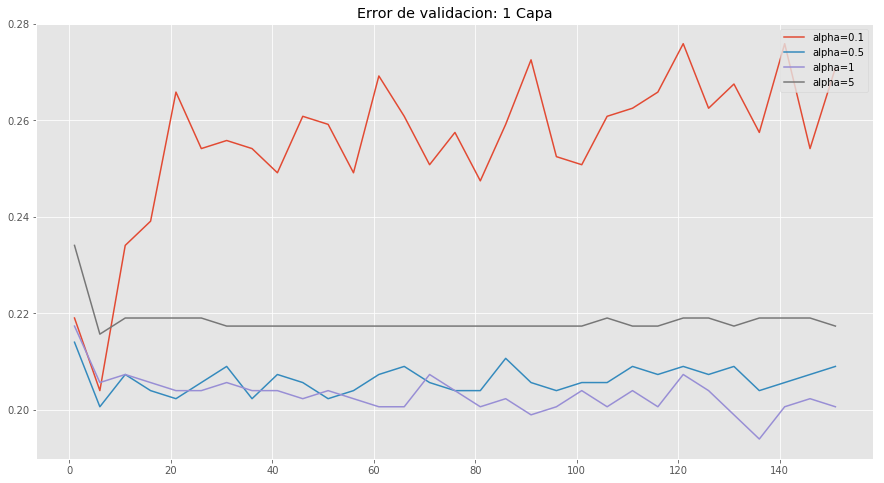

In [69]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion: 1 Capa")
#plt.errorbar(cv_results['param_hidden_layer_sizes'].str[0],1 - cv_results['mean_test_score'], cv_results['std_test_score'], label='entropy', capsize=3)  # 1 - [] para imprimir el error
plt.plot(cv_results_capa_1['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_1['param_alpha'] == 0.1] ,1 - cv_results_capa_1['mean_test_score'].loc[cv_results_capa_1['param_alpha'] == 0.1], label='alpha=0.1')
plt.plot(cv_results_capa_1['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_1['param_alpha'] == 0.5] ,1 - cv_results_capa_1['mean_test_score'].loc[cv_results_capa_1['param_alpha'] == 0.5], label='alpha=0.5')
plt.plot(cv_results_capa_1['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_1['param_alpha'] == 1] ,1 - cv_results_capa_1['mean_test_score'].loc[cv_results_capa_1['param_alpha'] == 1], label='alpha=1')
plt.plot(cv_results_capa_1['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_1['param_alpha'] == 5] ,1 - cv_results_capa_1['mean_test_score'].loc[cv_results_capa_1['param_alpha'] == 5], label='alpha=5')


plt.legend(loc='upper right')
plt.show()

- Fino

In [57]:
#fino 
one_layer = list()
for i in range(1, 101, 1):
    one_layer.append(tuple([i]))

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': one_layer,
                   'alpha': [0.1,0.5,1.0]} 
print(one_layer)

[(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,), (54,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,), (63,), (64,), (65,), (66,), (67,), (68,), (69,), (70,), (71,), (72,), (73,), (74,), (75,), (76,), (77,), (78,), (79,), (80,), (81,), (82,), (83,), (84,), (85,), (86,), (87,), (88,), (89,), (90,), (91,), (92,), (93,), (94,), (95,), (96,), (97,), (98,), (99,), (100,)]


In [58]:
mlp = MLPClassifier(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y) 

with open('MLPClassifier_capa_1_fino.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [33]:
with open('MLPClassifier_capa_1_fino.pkl', 'rb') as f:
    restored_model_capa_1_fino = pickle.load(f)

In [34]:
cv_results_capa_1_fino = pd.DataFrame(restored_model_capa_1_fino.cv_results_)
cv_results_capa_1_fino.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
0,tanh,"(1,)",0.1,0.780936,0.029936,208
1,tanh,"(2,)",0.1,0.801003,0.017331,7
2,tanh,"(3,)",0.1,0.802676,0.024302,2
3,tanh,"(4,)",0.1,0.784281,0.027736,204
4,tanh,"(5,)",0.1,0.784281,0.023175,204
5,tanh,"(6,)",0.1,0.795987,0.020638,72
6,tanh,"(7,)",0.1,0.794314,0.033404,121
7,tanh,"(8,)",0.1,0.782609,0.019985,206
8,tanh,"(9,)",0.1,0.779264,0.042152,210
9,tanh,"(10,)",0.1,0.780936,0.032249,208


In [35]:
cv_results_capa_1_fino_best = cv_results_capa_1_fino[cv_results_capa_1_fino['rank_test_score'] == 1 ]
cv_results_capa_1_fino_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
102,tanh,"(3,)",0.5,0.80602,0.032928,1


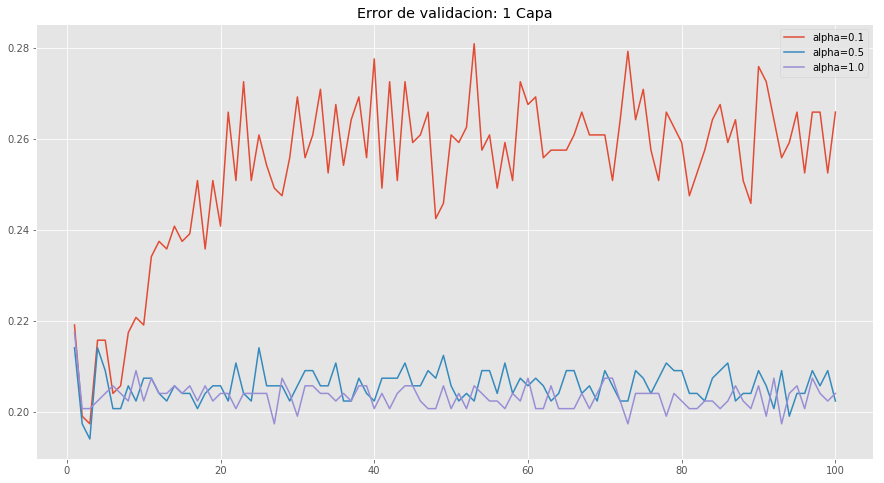

In [37]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion: 1 Capa")

alpha = [0.1,0.5,1.0]
for i in alpha:
    plt.plot(cv_results_capa_1_fino['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_1_fino['param_alpha'] == i] ,1 - cv_results_capa_1_fino['mean_test_score'].loc[cv_results_capa_1_fino['param_alpha'] == i], label='alpha=' + str(i))

plt.legend(loc='upper right')
plt.show()

### Con dos capas

- Grueso

In [67]:
two_layers = list()
for i in range(1, 102, 5):
    two_layers.append(tuple([i,i]))
print(len(two_layers))

alpha = list()
for i in range(1,6):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': two_layers,
                   'alpha': alpha} 

21


In [69]:
mlp = MLPClassifier(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)

with open('MLPClassifier_capa_2_grueso.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
with open('MLPClassifier_capa_2_grueso.pkl', 'rb') as f:
    restored_model_capa_2_grueso = pickle.load(f)

In [23]:
cv_results_capa_2_grueso = pd.DataFrame(restored_model_capa_2_grueso.cv_results_)

In [24]:
cv_results_capa_2_grueso_best = cv_results_capa_2_grueso[cv_results_capa_2_grueso['rank_test_score'] == 1]
cv_results_capa_2_grueso_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
181,tanh,"(66, 66)",1,0.795987,0.022986,1
184,tanh,"(81, 81)",1,0.795987,0.021729,1
187,tanh,"(96, 96)",1,0.795987,0.018967,1


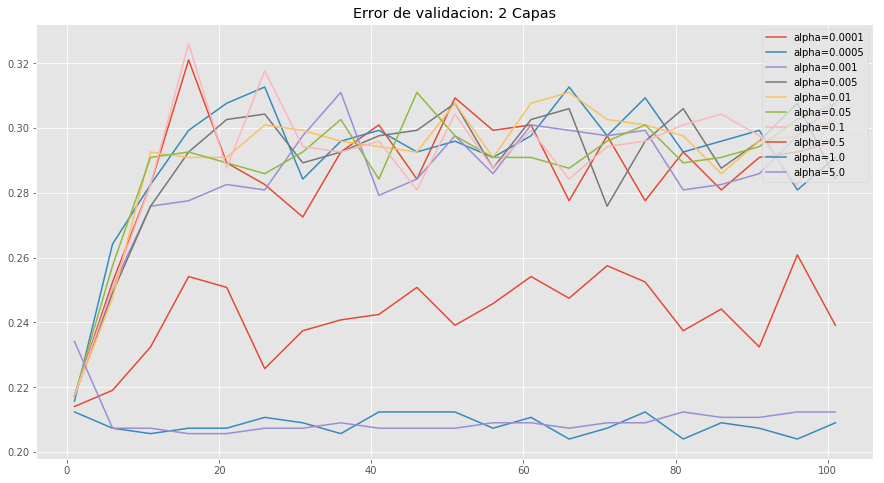

In [26]:
alpha = list()
for i in range(1,6):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)

plt.figure(figsize=(15,8))
plt.title("Error de validacion: 2 Capas")
for i in alpha:
        plt.plot(cv_results_capa_2_grueso['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_2_grueso['param_alpha'] == i] ,1 - cv_results_capa_2_grueso['mean_test_score'].loc[cv_results_capa_2_grueso['param_alpha'] == i], label='alpha=' + str(i))
    
plt.legend(loc='upper right')
plt.show()

- Fino

In [16]:
two_layers = list()
for i in range(1, 101, 1):
    two_layers.append(tuple([i,i]))
print(len(two_layers))

alpha = [0.5,1,5]

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': two_layers,
                   'alpha': alpha} 

100


In [ ]:
mlp = MLPClassifier(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)

#with open('MLP_Classifier_100_1_capa2_fino.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open('MLP_Classifier_100_1_capa2_fino.pkl', 'rb') as f:
    restored_model_capa_2_fino = pickle.load(f)

In [18]:
cv_results_capa_2_fino = pd.DataFrame(restored_model_capa_2_fino.cv_results_)

In [19]:
cv_results_capa_2_fino_best = cv_results_capa_2_fino[cv_results_capa_2_fino['rank_test_score'] == 1]
cv_results_capa_2_fino_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
101,tanh,"(2, 2)",1,0.802676,0.02738,1


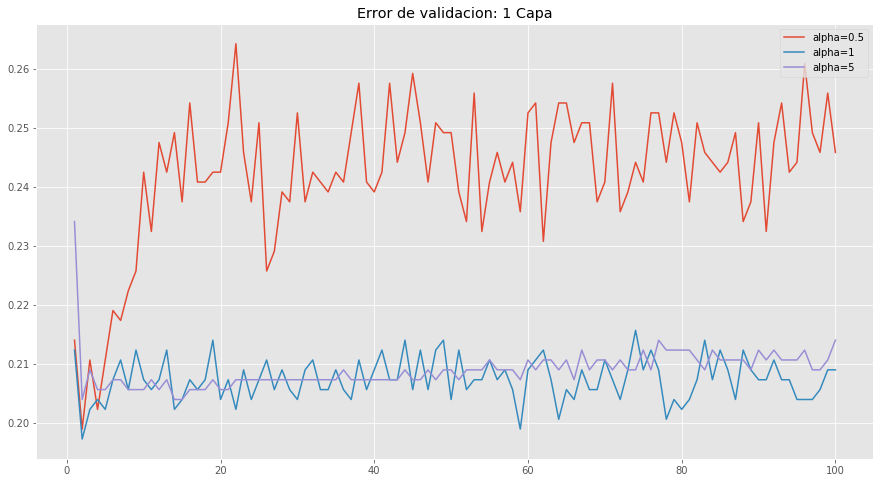

In [20]:
alpha = [0.5,1,5]

plt.figure(figsize=(15,8))
plt.title("Error de validacion: 1 Capa")
for i in alpha:
        plt.plot(cv_results_capa_2_fino['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_2_fino['param_alpha'] == i] ,1 - cv_results_capa_2_fino['mean_test_score'].loc[cv_results_capa_2_fino['param_alpha'] == i], label='alpha=' + str(i))
    
plt.legend(loc='upper right')
plt.show()

### Con tres capas


- Grueso

In [65]:
two_layers = list()
for i in range(1, 152, 5):
    one_layer.append(tuple([i,i]))
print(len(two_layers))

alpha = list()
for i in range(1,8):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': three_layers,
                   'alpha': alpha} 

In [67]:
mlp = MLPClassifier(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)  

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 0.5, 1.0, 5.0], 'activation': ['tanh'], 'max_iter': [2000], 'hidden_layer_sizes': [(1, 1, 1), (6, 6, 6), (11, 11, 11), (16, 16, 16), (21, 21, 21), (26, 26, 26), (31, 31, 31), (36, 36, 36), (41, 41, 41), (46, 46, 46), (51, 51, 51), (56, 56, 56), (61, 61, 61), (66, 66, 66), ...131, 131), (136, 136, 136), (141, 141, 141), (146, 146, 146), (151, 151, 151)], 'solver': ['lbfgs']},
       pre_dispat

In [ ]:
#with open('MLP_150_5_alpha_4_capa_3.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
with open('MLP_150_5_alpha_4_capa_3.pkl', 'rb') as f:
    restored_model_capa_3 = pickle.load(f)

In [72]:
cv_results_capa_3 = pd.DataFrame(restored_model_capa_3.cv_results_)

In [73]:
cv_results_capa_3_best = cv_results_capa_3[cv_results_capa_3['rank_test_score'] == 1]
cv_results_capa_3_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
85,tanh,"(116, 116, 116)",1,0.799331,0.021329,1


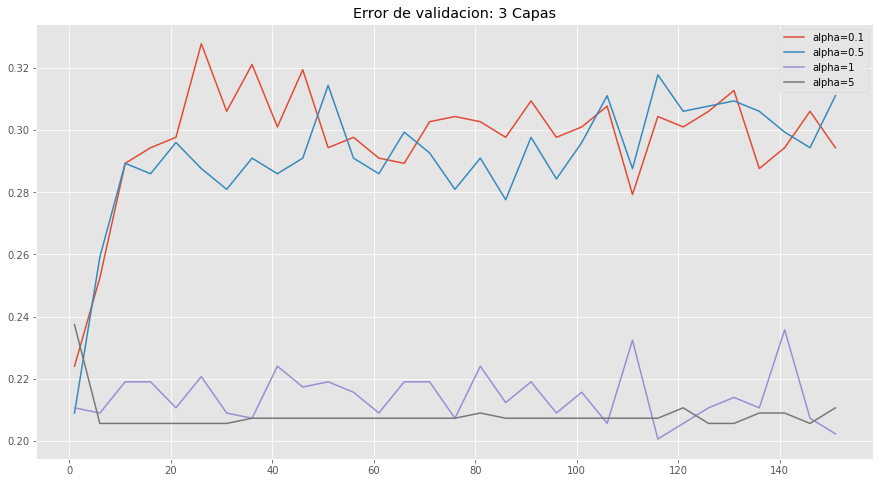

In [74]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion: 3 Capas")
#plt.errorbar(cv_results['param_hidden_layer_sizes'].str[0],1 - cv_results['mean_test_score'], cv_results['std_test_score'], label='entropy', capsize=3)  # 1 - [] para imprimir el error
plt.plot(cv_results_capa_3['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_3['param_alpha'] == 0.1] ,1 - cv_results_capa_3['mean_test_score'].loc[cv_results_capa_3['param_alpha'] == 0.1], label='alpha=0.1')
plt.plot(cv_results_capa_3['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_3['param_alpha'] == 0.5] ,1 - cv_results_capa_3['mean_test_score'].loc[cv_results_capa_3['param_alpha'] == 0.5], label='alpha=0.5')
plt.plot(cv_results_capa_3['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_3['param_alpha'] == 1] ,1 - cv_results_capa_3['mean_test_score'].loc[cv_results_capa_3['param_alpha'] == 1], label='alpha=1')
plt.plot(cv_results_capa_3['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_3['param_alpha'] == 5] ,1 - cv_results_capa_3['mean_test_score'].loc[cv_results_capa_3['param_alpha'] == 5], label='alpha=5')


plt.legend(loc='upper right')
plt.show()

- Fino

### Creación de un modelo con los mejores hiperparámetros

"Entrenamos" un modelo con el menor error de validación cruzada (`hidden_layer_sizes = (3,)`, `alpha = '0.5'`) y con todo el conjunto de entrenamiento. 

In [63]:
model = MLPClassifier(hidden_layer_sizes = (3,), alpha = 0.5, random_state=SEED_VALUE,
                     activation = 'tanh', solver = 'lbfgs', max_iter = 2000)

np.random.seed(SEED_VALUE)  
model.fit(dataset_train_X_scaled, dataset_train_Y)

MLPClassifier(activation='tanh', alpha=0.5, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### Evaluación del modelo en el conjunto de test

Después de "entrenar" el modelo con todo el conjunto de entrenamiento ya los podemos aplicar al conjunto de test. Guardamos la predicción del modelo en la variable Z.

In [64]:
np.random.seed(SEED_VALUE)
Z = model.predict(dataset_test_X_scaled)

Hacemos una comparación entre las predicciones en Z y los valores reales.

In [65]:
accuracy_test = accuracy_score(dataset_test_Y, Z) 
print("Accuracy en test: {}  |  Error en test: {}".format(accuracy_test, 1-accuracy_test))

Accuracy en test: 0.8  |  Error en test: 0.2


### Verificación de nuestros hiperparámetros

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo y nuestro conjunto de validación va a ser el conjunto de test.

In [74]:
one_layer = list()
for i in range(1, 101, 1):
    one_layer.append(tuple([i]))

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': one_layer,
                   'alpha': [0.1,0.5,1.0]} 
print(one_layer)

[(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,), (54,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,), (63,), (64,), (65,), (66,), (67,), (68,), (69,), (70,), (71,), (72,), (73,), (74,), (75,), (76,), (77,), (78,), (79,), (80,), (81,), (82,), (83,), (84,), (85,), (86,), (87,), (88,), (89,), (90,), (91,), (92,), (93,), (94,), (95,), (96,), (97,), (98,), (99,), (100,)]


In [76]:
# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold) #divicion de datos

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y]) 

mlp = MLPClassifier(random_state=SEED_VALUE)
modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=ps, 
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_all_X_scaled, dataset_all_Y)

with open('MLPClassifier_test.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

Obtenemos los resultados de la validación con el conjunto de test.

In [78]:
with open('MLPClassifier_test.pkl', 'rb') as f:
    restored_model_test = pickle.load(f)
test_results = pd.DataFrame(restored_model_test.cv_results_)

Vizualizamos el error en el conjunto de entrenamiento y también el error en el conjunto de test para ver si nuestro modelo ha hecho buen trabajo.

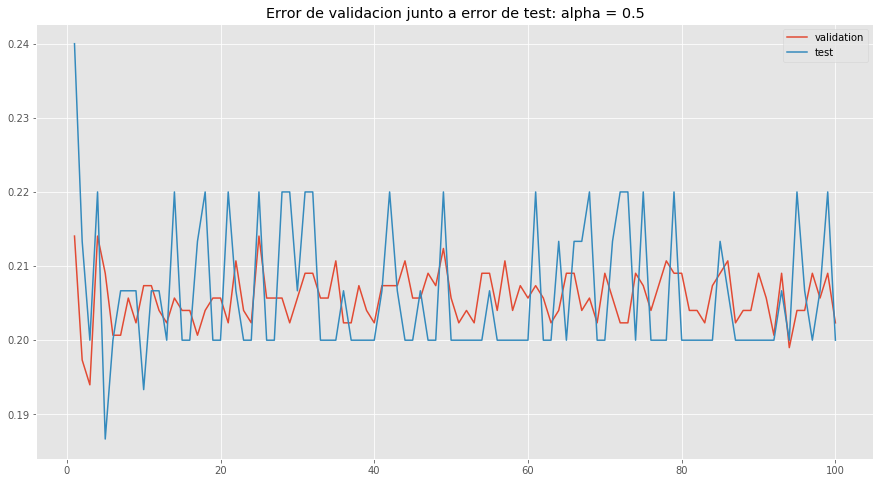

In [82]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion junto a error de test: alpha = 0.5")

plt.plot(cv_results_capa_1_fino['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_1_fino['param_alpha'] == 0.5] ,1 - cv_results_capa_1_fino['mean_test_score'].loc[cv_results_capa_1_fino['param_alpha'] == 0.5], label='validation')
plt.plot(test_results['param_hidden_layer_sizes'].str[0].loc[test_results['param_alpha'] == 0.5] ,1 - test_results['mean_test_score'].loc[test_results['param_alpha'] == 0.5], label='test')

plt.legend(loc='upper right')
plt.show()


## Ejercicio 3: Regresión - Energy Efficiency

In [4]:
DATASET_NAME = 'EnergyEfficiency.data'
DATASET_DELIMITER = ','

### Leemos el fichero de datos

In [5]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1,
                      names = ["X1", "X2", "X3", "X4", "X5","X6","X7","X8","Y2"])
dataset

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,21.97


El fichero contiene 9 variables y 758 observaciones distintas. Las variables predictoras son 8 en total nombradas de `X0` a `X8`, y la variable dependiente sería `Y2`. Estamos ante un problema de regresión ya que la variable de salida es una variable continua.

### Visualizamos los datos

También podemos visualizar los datos y sus clases por pares de atributos:

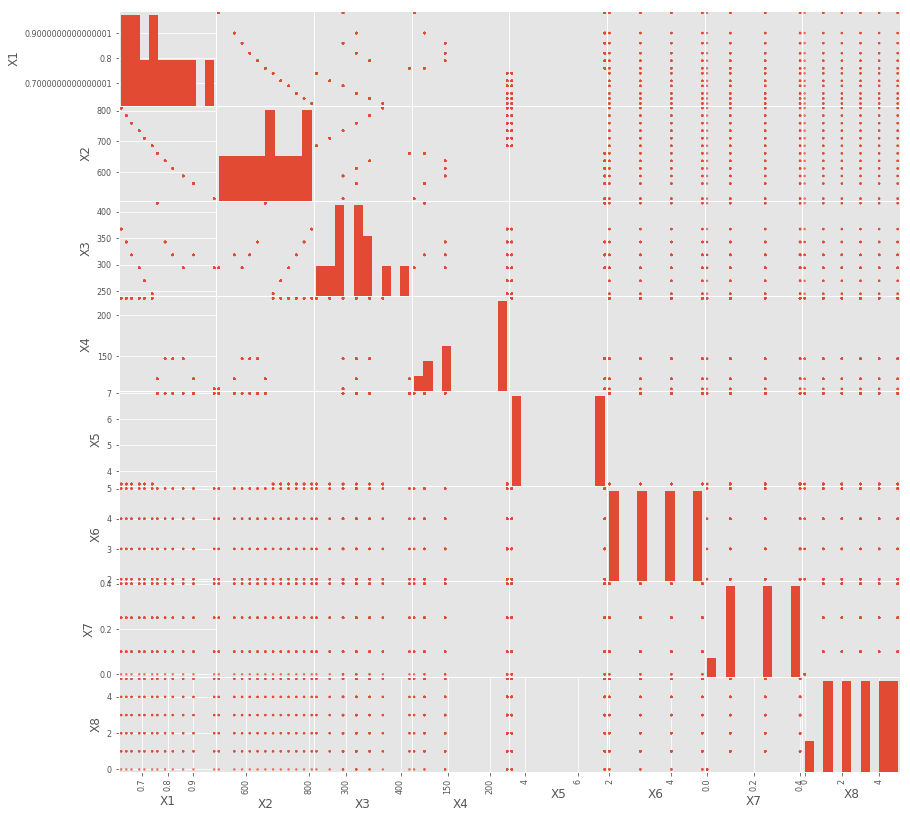

In [6]:
axes = pd.plotting.scatter_matrix(dataset.loc[:, dataset.columns != 'Y2'], alpha=0.3, figsize=(14,14), s=20)

#for i in range(np.shape(axes)[0]):
#    for j in range(np.shape(axes)[1]):
#        if i <= j:
#            axes[i,j].set_visible(False)

### División de los datos en entrenamiento (80%) y test (20%):

In [6]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE, stratify=None)
dataset_test

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
285,0.62,808.5,367.5,220.50,3.5,3,0.10,5,13.97
101,0.90,563.5,318.5,122.50,7.0,3,0.10,2,29.44
581,0.90,563.5,318.5,122.50,7.0,3,0.40,2,35.39
352,0.79,637.0,343.0,147.00,7.0,2,0.25,2,43.86
726,0.90,563.5,318.5,122.50,7.0,4,0.40,5,38.79
472,0.64,784.0,343.0,220.50,3.5,2,0.25,4,19.65
233,0.64,784.0,343.0,220.50,3.5,3,0.10,4,19.25
385,0.98,514.5,294.0,110.25,7.0,3,0.25,3,29.78
556,0.71,710.5,269.5,220.50,3.5,2,0.40,1,17.10
59,0.86,588.0,294.0,147.00,7.0,5,0.10,1,31.73


### Separación de variables predictoras y dependientes

In [7]:
dataset_train_X = dataset_train.loc[:, "X1":"X8"].astype(float)
dataset_train_Y = dataset_train.loc[:, ["Y2"]].astype(float)

dataset_test_X = dataset_test.loc[:, "X1":"X8"].astype(float)
dataset_test_Y = dataset_test.loc[:, ["Y2"]].astype(float)

dataset_test_X

,X1,X2,X3,X4,X5,X6,X7,X8
285,0.62,808.5,367.5,220.50,3.5,3.0,0.10,5.0
101,0.90,563.5,318.5,122.50,7.0,3.0,0.10,2.0
581,0.90,563.5,318.5,122.50,7.0,3.0,0.40,2.0
352,0.79,637.0,343.0,147.00,7.0,2.0,0.25,2.0
726,0.90,563.5,318.5,122.50,7.0,4.0,0.40,5.0
472,0.64,784.0,343.0,220.50,3.5,2.0,0.25,4.0
233,0.64,784.0,343.0,220.50,3.5,3.0,0.10,4.0
385,0.98,514.5,294.0,110.25,7.0,3.0,0.25,3.0
556,0.71,710.5,269.5,220.50,3.5,2.0,0.40,1.0
59,0.86,588.0,294.0,147.00,7.0,5.0,0.10,1.0


### Estandarización de los datos

Primero estandarizamos las variables de entrada.

In [8]:
scaler = StandardScaler()

#calculamos la media y la desviacion sobre el conjunto de entrenamiento, no sobre todo el conjunto
scaler.fit(dataset_train_X)

#las dos estandarizamos con la media y sd del entremanieto (el mismo scaler para los dos)
dataset_train_X_scaled = scaler.transform(dataset_train_X)
dataset_test_X_scaled = scaler.transform(dataset_test_X)

dataset_test_X_scaled
#en problemas de regresion lo tenemos que hacer tambien para la vatiable de salida

array([[-1.33525558,  1.52364121,  1.12278518, ..., -0.42346954,
        -0.99633936,  1.40105783],
       [ 1.28346607, -1.23517832,  0.00816901, ..., -0.42346954,
        -0.99633936, -0.54374136],
       [ 1.28346607, -1.23517832,  0.00816901, ..., -0.42346954,
         1.26941014, -0.54374136],
       ...,
       [ 0.90936298, -0.95929637, -0.54913907, ...,  0.47003664,
        -0.99633936,  0.10452504],
       [ 0.53525988, -0.68341441,  0.00816901, ..., -1.31697573,
         1.26941014,  0.75279143],
       [ 0.25468256, -0.40753246,  0.56547709, ...,  1.36354282,
         1.26941014,  0.10452504]])

Estos son los valores con los que se ha estandarizado.

In [9]:
print("mean [X1,X2,X3,X4,X5,X6,X7,X8]: {}  |  std [X1,X2,X3,X4,X5,X6,X7,X8]: {}".format(scaler.mean_, scaler.scale_))

mean [X1,X2,X3,X4,X5,X6,X7,X8]: [7.62768730e-01 6.73191368e+02 3.18140879e+02 1.77525244e+02
 5.19869707e+00 3.47394137e+00 2.31921824e-01 2.83876221e+00]  |  std [X1,X2,X3,X4,X5,X6,X7,X8]: [ 0.1069224  88.80609907 43.96132191 45.46444155  1.74924784  1.11918644
  0.13240652  1.54257571]


Después estandarizamos la variable de salida porque es un problem de regresión.

In [10]:
scaler_y = StandardScaler()

#calculamos la media y la desviacion sobre el conjunto de entrenamiento, no sobre todo el conjunto
scaler_y.fit(dataset_train_Y)

#las dos estandarizamos con la media y sd del entremanieto (el mismo scaler para los dos)
dataset_train_Y_scaled = scaler_y.transform(dataset_train_Y)
dataset_test_Y_scaled = scaler_y.transform(dataset_test_Y)

dataset_test_Y_scaled
#en problemas de regresion lo tenemos que hacer tambien para la vatiable de salida

array([[-1.09538181],
       [ 0.54110007],
       [ 1.17051617],
       [ 2.06650851],
       [ 1.53018252],
       [-0.49452744],
       [-0.53684113],
       [ 0.5770667 ],
       [-0.7642772 ],
       [ 0.78334593],
       [-0.70715372],
       [ 0.87960957],
       [ 0.54004222],
       [-0.63098909],
       [-0.88169769],
       [ 2.28971321],
       [ 1.59894226],
       [-0.64368319],
       [-0.99806033],
       [ 1.030881  ],
       [ 0.18566509],
       [-1.17577782],
       [ 0.06401324],
       [-0.29565311],
       [-0.74840957],
       [ 1.36833266],
       [-0.73677331],
       [-1.0625887 ],
       [ 2.33943179],
       [-0.95151527],
       [ 0.93144383],
       [ 1.27524255],
       [-0.98642406],
       [-0.89439179],
       [ 0.7124705 ],
       [ 2.46108365],
       [-0.37075991],
       [-1.12182786],
       [ 1.32707682],
       [-0.76216152],
       [ 1.30063076],
       [-1.00652306],
       [-1.29954535],
       [-0.53260976],
       [-1.06153086],
       [-0

In [11]:
print("mean [Y2]: {}  |  std [Y2]: {}".format(scaler_y.mean_, scaler_y.scale_))

mean [Y2]: [24.32486971]  |  std [Y2]: [9.45320583]


### Empezamos con la experimentación MLP

## 1 capa

- Grueso

### Definimos un rango de hiperparámetros para realizar las pruebas

In [18]:
one_layer = list()
for i in range(1, 152, 5):
    one_layer.append(tuple([i]))

alpha = list()
for i in range(1,6):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': one_layer,
                   'alpha': alpha} 
print(one_layer)
print(alpha)

[(1,), (6,), (11,), (16,), (21,), (26,), (31,), (36,), (41,), (46,), (51,), (56,), (61,), (66,), (71,), (76,), (81,), (86,), (91,), (96,), (101,), (106,), (111,), (116,), (121,), (126,), (131,), (136,), (141,), (146,), (151,)]
[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]


### Comenzamos las pruebas con 5-CV

In [19]:
mlp = MLPRegressor(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='neg_mean_squared_error',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y_scaled)  

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0], 'activation': ['tanh'], 'max_iter': [2000], 'hidden_layer_sizes': [(1,), (6,), (11,), (16,), (21,), (26,), (31,), (36,), (41,), (46,), (51,), (56,), (61,), (66,), (71,), (76,), (81,), (86,), (91,), (96,), (101,), (106,), (111,), (116,), (121,), (126,), (131,), (136,), (141,), (146,), (151,)], 'solver': ['lbfgs']},
       pre_dispatch='2

In [42]:
with open('MLPRegressor_capa_1_grueso.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

### Resultados obtenidos en 5-CV

Podemos ver el ranking de los mejores hiperparámetros.

In [42]:
with open('MLPRegressor_capa_1_grueso.pkl', 'rb') as f:
    restored_model_capa_1 = pickle.load(f)

In [43]:
cv_results_capa_1 = pd.DataFrame(restored_model_capa_1.cv_results_)
cv_results_capa_1.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
0,tanh,"(1,)",0.0001,-0.104019,0.002335,307
1,tanh,"(6,)",0.0001,-0.027741,0.005501,235
2,tanh,"(11,)",0.0001,-0.020569,0.005879,229
3,tanh,"(16,)",0.0001,-0.012432,0.006426,167
4,tanh,"(21,)",0.0001,-0.011383,0.003186,112
5,tanh,"(26,)",0.0001,-0.009206,0.001809,6
6,tanh,"(31,)",0.0001,-0.010267,0.002147,44
7,tanh,"(36,)",0.0001,-0.012202,0.006298,157
8,tanh,"(41,)",0.0001,-0.010575,0.004207,59
9,tanh,"(46,)",0.0001,-0.009477,0.000968,14


Estandarizamos el error multiplicando por la varianza de Y.

In [44]:
cv_results_capa_1['mean_test_score'] = cv_results_capa_1['mean_test_score'] *((scaler_y.scale_)**2)
cv_results_capa_1['std_test_score'] = cv_results_capa_1['std_test_score'] *((scaler_y.scale_)**2)

In [45]:
cv_results_capa_1_best = cv_results_capa_1[cv_results_capa_1['rank_test_score'] == 1]
cv_results_capa_1_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
38,tanh,"(36,)",0.0005,-0.757397,0.095205,1


### Gráfica de entrenamiento

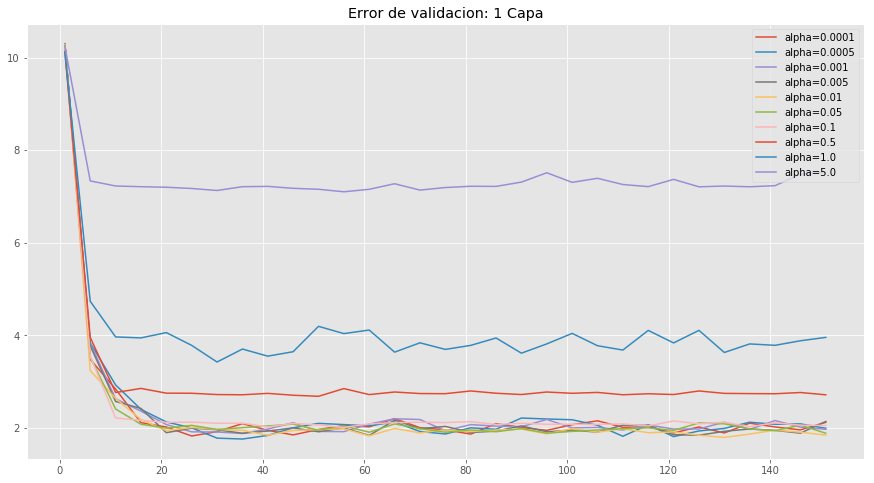

In [46]:
alpha = list()
for i in range(1,6):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)

plt.figure(figsize=(15,8))
plt.title("Error de validacion: 1 Capa")
for i in alpha:
        plt.plot(cv_results_capa_1['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_1['param_alpha'] == i] ,1 - cv_results_capa_1['mean_test_score'].loc[cv_results_capa_1['param_alpha'] == i], label='alpha=' + str(i))
    
plt.legend(loc='upper right')
plt.show()

- Fino

In [13]:
#fino
one_layer = list()
for i in range(1, 102, 1):
    one_layer.append(tuple([i]))

alpha = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]


hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': one_layer,
                   'alpha': alpha} 
print(one_layer)
print(alpha)

[(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,), (54,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,), (63,), (64,), (65,), (66,), (67,), (68,), (69,), (70,), (71,), (72,), (73,), (74,), (75,), (76,), (77,), (78,), (79,), (80,), (81,), (82,), (83,), (84,), (85,), (86,), (87,), (88,), (89,), (90,), (91,), (92,), (93,), (94,), (95,), (96,), (97,), (98,), (99,), (100,), (101,)]
[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]


In [14]:
mlp = MLPRegressor(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='neg_mean_squared_error',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y_scaled) 

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05], 'activation': ['tanh'], 'max_iter': [2000], 'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (2...(91,), (92,), (93,), (94,), (95,), (96,), (97,), (98,), (99,), (100,), (101,)], 'solver': ['lbfgs']},
       pre_dispatc

In [15]:
with open('MLPRegressor_capa_1_fino.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open('MLPRegressor_capa_1_fino.pkl', 'rb') as f:
    restored_model_capa_1_fino = pickle.load(f)

In [17]:
cv_results_capa_1_fino = pd.DataFrame(restored_model_capa_1_fino.cv_results_)
cv_results_capa_1_fino.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
0,tanh,"(1,)",0.0001,-0.104019,0.002335,603
1,tanh,"(2,)",0.0001,-0.052960,0.004071,596
2,tanh,"(3,)",0.0001,-0.036154,0.004971,590
3,tanh,"(4,)",0.0001,-0.031001,0.007807,577
4,tanh,"(5,)",0.0001,-0.029155,0.003057,575
5,tanh,"(6,)",0.0001,-0.027741,0.005501,572
6,tanh,"(7,)",0.0001,-0.023161,0.004315,567
7,tanh,"(8,)",0.0001,-0.019480,0.003987,557
8,tanh,"(9,)",0.0001,-0.017301,0.003979,549
9,tanh,"(10,)",0.0001,-0.019525,0.011098,559


In [18]:
cv_results_capa_1_fino['mean_test_score'] = cv_results_capa_1_fino['mean_test_score'] *((scaler_y.scale_)**2)
cv_results_capa_1_fino['std_test_score'] = cv_results_capa_1_fino['std_test_score'] *((scaler_y.scale_)**2)

In [25]:
cv_results_capa_1__fino_best = cv_results_capa_1_fino[cv_results_capa_1_fino['rank_test_score'] == 1]
cv_results_capa_1__fino_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
337,tanh,"(35,)",0.005,-0.754372,0.187843,1


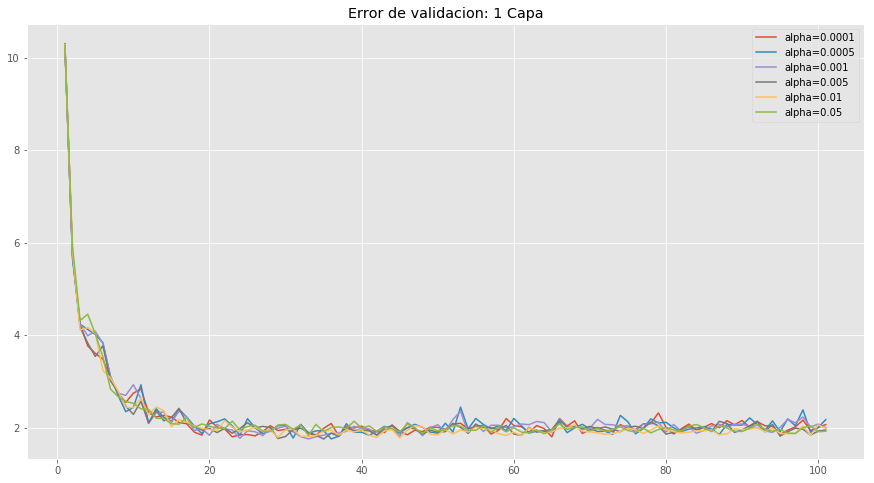

In [24]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion: 1 Capa")
for i in alpha:
        plt.plot(cv_results_capa_1_fino['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_1_fino['param_alpha'] == i] ,1 - cv_results_capa_1_fino['mean_test_score'].loc[cv_results_capa_1_fino['param_alpha'] == i], label='alpha=' + str(i))
    
plt.legend(loc='upper right')
plt.show()

## 2 capas

- Grueso

In [12]:
two_layers = list()
for i in range(1, 101, 5):
    two_layers.append(tuple([i,i]))

alpha = list()
for i in range(1,6):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': two_layers,
                   'alpha': alpha} 
print(two_layers)
print(alpha)

[(1, 1), (6, 6), (11, 11), (16, 16), (21, 21), (26, 26), (31, 31), (36, 36), (41, 41), (46, 46), (51, 51), (56, 56), (61, 61), (66, 66), (71, 71), (76, 76), (81, 81), (86, 86), (91, 91), (96, 96)]
[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]


In [13]:
mlp = MLPRegressor(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='neg_mean_squared_error',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y_scaled)

with open('MLPRegressor_capa_2_grueso.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
with open('MLPRegressor_capa_2_grueso.pkl', 'rb') as f:
    restored_model_capa_2_grueso = pickle.load(f)

In [15]:
cv_results_capa_2_grueso = pd.DataFrame(restored_model_capa_2_grueso.cv_results_)

In [16]:
cv_results_capa_2_grueso['mean_test_score'] = cv_results_capa_2_grueso['mean_test_score'] *((scaler_y.scale_)**2)
cv_results_capa_2_grueso['std_test_score'] = cv_results_capa_2_grueso['std_test_score'] *((scaler_y.scale_)**2)

In [18]:
cv_results_capa_2_grueso_best = cv_results_capa_2_grueso[cv_results_capa_2_grueso['rank_test_score'] == 1]
cv_results_capa_2_grueso_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
102,tanh,"(11, 11)",0.05,-0.550356,0.076533,1


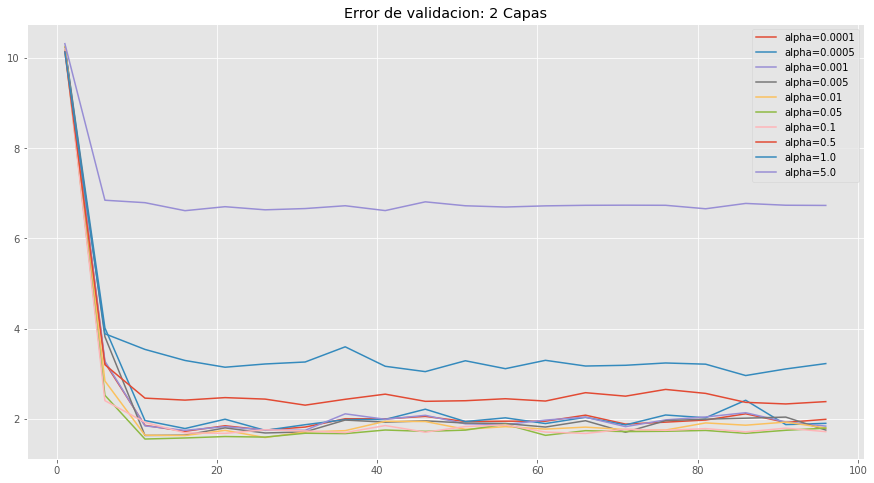

In [20]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion: 2 Capas")
alpha = list()
for i in range(1,6):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)
    
for i in alpha:
        plt.plot(cv_results_capa_2_grueso['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_2_grueso['param_alpha'] == i] ,1 - cv_results_capa_2_grueso['mean_test_score'].loc[cv_results_capa_2_grueso['param_alpha'] == i], label='alpha=' + str(i))
    
plt.legend(loc='upper right')
plt.show()

- Fino

## Capas 3 

In [27]:
three_layers = list()
for i in range(1, 152, 5):
    three_layers.append(tuple([i,i,i]))

alpha = list()
for i in range(1,6):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': three_layers,
                   'alpha': alpha} 
print(three_layers)
print(alpha)

[(1, 1, 1), (6, 6, 6), (11, 11, 11), (16, 16, 16), (21, 21, 21), (26, 26, 26), (31, 31, 31), (36, 36, 36), (41, 41, 41), (46, 46, 46), (51, 51, 51), (56, 56, 56), (61, 61, 61), (66, 66, 66), (71, 71, 71), (76, 76, 76), (81, 81, 81), (86, 86, 86), (91, 91, 91), (96, 96, 96), (101, 101, 101), (106, 106, 106), (111, 111, 111), (116, 116, 116), (121, 121, 121), (126, 126, 126), (131, 131, 131), (136, 136, 136), (141, 141, 141), (146, 146, 146), (151, 151, 151)]
[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]


In [28]:
mlp = MLPRegressor(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='neg_mean_squared_error',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y_scaled) 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0], 'activation': ['tanh'], 'max_iter': [2000], 'hidden_layer_sizes': [(1, 1, 1), (6, 6, 6), (11, 11, 11), (16, 16, 16), (21, 21, 21), (26, 26, 26), (31, 31, 31), (36, 36, 36), (41, 41, 41), (46, 46, 46), (51, 51, 51), ...131, 131), (136, 136, 136), (141, 141, 141), (146, 146, 146), (151, 151, 151)], 'solver': ['lbfgs']},
       pre_dispatc

In [29]:
#with open('MLPRegressor_capa_3_grueso.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
with open('MLPRegressor_capa_3_grueso.pkl', 'rb') as f:
    restored_model_capa_3_grueso = pickle.load(f)

In [31]:
cv_results_capa_3_grueso = pd.DataFrame(restored_model_capa_3_grueso.cv_results_)
cv_results_capa_3_grueso.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
0,tanh,"(1, 1, 1)",0.0001,-0.133102,0.038354,310
1,tanh,"(6, 6, 6)",0.0001,-0.043973,0.027460,270
2,tanh,"(11, 11, 11)",0.0001,-0.017285,0.007887,233
3,tanh,"(16, 16, 16)",0.0001,-0.011209,0.005881,179
4,tanh,"(21, 21, 21)",0.0001,-0.008171,0.002620,83
5,tanh,"(26, 26, 26)",0.0001,-0.010491,0.004700,166
6,tanh,"(31, 31, 31)",0.0001,-0.011798,0.004091,189
7,tanh,"(36, 36, 36)",0.0001,-0.016687,0.008886,232
8,tanh,"(41, 41, 41)",0.0001,-0.008720,0.002221,104
9,tanh,"(46, 46, 46)",0.0001,-0.009369,0.003580,130


In [32]:
cv_results_capa_3_grueso['mean_test_score'] = cv_results_capa_3_grueso['mean_test_score'] *((scaler_y.scale_)**2)
cv_results_capa_3_grueso['std_test_score'] = cv_results_capa_3_grueso['std_test_score'] *((scaler_y.scale_)**2)

In [33]:
cv_results_capa_3_grueso_best = cv_results_capa_3_grueso[cv_results_capa_3_grueso['rank_test_score'] == 1]
cv_results_capa_3_grueso_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
159,tanh,"(21, 21, 21)",0.05,-0.514391,0.085244,1


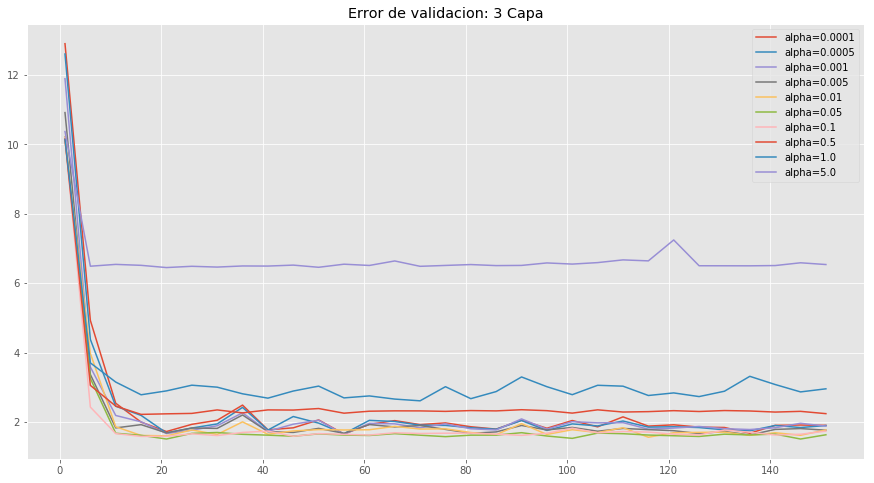

In [43]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion: 3 Capa")
alpha = list()
for i in range(1,6):
    alpha.append(0.00001*10**i)
    alpha.append(0.00005*10**i)
    
for i in alpha:
        plt.plot(cv_results_capa_3_grueso['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_3_grueso['param_alpha'] == i] ,1 - cv_results_capa_3_grueso['mean_test_score'].loc[cv_results_capa_3_grueso['param_alpha'] == i], label='alpha=' + str(i))
    
plt.legend(loc='upper right')
plt.show()

- Fino

In [47]:
#fino
three_layers = list()
for i in range(1, 102, 1):
    three_layers.append(tuple([i,i,i]))

alpha = [0.01,0.05,0.1]

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': three_layers,
                   'alpha': alpha} 
print(three_layers)
print(alpha)

[(1, 1, 1), (2, 2, 2), (3, 3, 3), (4, 4, 4), (5, 5, 5), (6, 6, 6), (7, 7, 7), (8, 8, 8), (9, 9, 9), (10, 10, 10), (11, 11, 11), (12, 12, 12), (13, 13, 13), (14, 14, 14), (15, 15, 15), (16, 16, 16), (17, 17, 17), (18, 18, 18), (19, 19, 19), (20, 20, 20), (21, 21, 21), (22, 22, 22), (23, 23, 23), (24, 24, 24), (25, 25, 25), (26, 26, 26), (27, 27, 27), (28, 28, 28), (29, 29, 29), (30, 30, 30), (31, 31, 31), (32, 32, 32), (33, 33, 33), (34, 34, 34), (35, 35, 35), (36, 36, 36), (37, 37, 37), (38, 38, 38), (39, 39, 39), (40, 40, 40), (41, 41, 41), (42, 42, 42), (43, 43, 43), (44, 44, 44), (45, 45, 45), (46, 46, 46), (47, 47, 47), (48, 48, 48), (49, 49, 49), (50, 50, 50), (51, 51, 51), (52, 52, 52), (53, 53, 53), (54, 54, 54), (55, 55, 55), (56, 56, 56), (57, 57, 57), (58, 58, 58), (59, 59, 59), (60, 60, 60), (61, 61, 61), (62, 62, 62), (63, 63, 63), (64, 64, 64), (65, 65, 65), (66, 66, 66), (67, 67, 67), (68, 68, 68), (69, 69, 69), (70, 70, 70), (71, 71, 71), (72, 72, 72), (73, 73, 73), (74,

In [48]:
mlp = MLPRegressor(random_state=SEED_VALUE)

modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=5, 
                       scoring='neg_mean_squared_error',
                       return_train_score=True) 

np.random.seed(SEED_VALUE) 
modelCV.fit(dataset_train_X_scaled, dataset_train_Y_scaled) 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.01, 0.05, 0.1], 'activation': ['tanh'], 'max_iter': [2000], 'hidden_layer_sizes': [(1, 1, 1), (2, 2, 2), (3, 3, 3), (4, 4, 4), (5, 5, 5), (6, 6, 6), (7, 7, 7), (8, 8, 8), (9, 9, 9), (10, 10, 10), (11, 11, 11), (12, 12, 12), (13, 13, 13), (14, 14, 14), (15, 15, 15), (16, 16, 1...), (97, 97, 97), (98, 98, 98), (99, 99, 99), (100, 100, 100), (101, 101, 101)], 'solver': ['lbfgs']},
       pre_dispatc

In [49]:
#with open('MLPRegressor_capa_3_fino.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open('MLPRegressor_capa_3_fino.pkl', 'rb') as f:
    restored_model_capa_3_fino = pickle.load(f)

In [18]:
cv_results_capa_3_fino = pd.DataFrame(restored_model_capa_3_fino.cv_results_)

In [19]:
cv_results_capa_3_fino['mean_test_score'] = cv_results_capa_3_fino['mean_test_score'] *((scaler_y.scale_)**2)
cv_results_capa_3_fino['std_test_score'] = cv_results_capa_3_fino['std_test_score'] *((scaler_y.scale_)**2)

In [20]:
cv_results_capa_3_fino_best = cv_results_capa_3_fino[cv_results_capa_3_fino['rank_test_score'] == 1]
cv_results_capa_3_fino_best.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
220,tanh,"(19, 19, 19)",0.1,-0.476632,0.076583,1


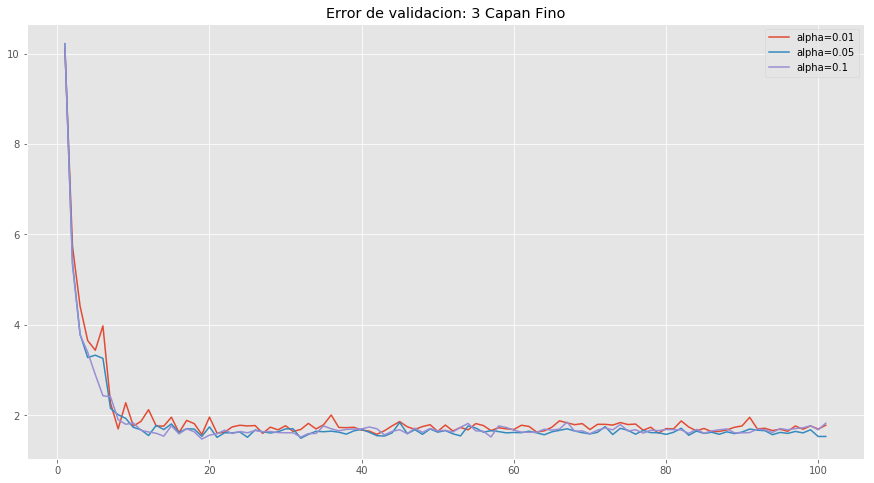

In [21]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion: 3 Capan Fino")
alpha = [0.01,0.05,0.1]
for i in alpha:
        plt.plot(cv_results_capa_3_fino['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_3_fino['param_alpha'] == i] ,1 - cv_results_capa_3_fino['mean_test_score'].loc[cv_results_capa_3_fino['param_alpha'] == i], label='alpha=' + str(i))
    
plt.legend(loc='upper right')
plt.show()

## Creación de un modelo con los mejores hiperparámetros

"Entrenamos" un modelo con el menor error de validación cruzada (`hidden_layer_sizes = (19,19,19)`, `alpha = 0.1`) y con todo el conjunto de entrenamiento.

In [40]:
model = MLPRegressor(hidden_layer_sizes = (19,19,19), alpha = 0.1, random_state=SEED_VALUE,
                     activation = 'tanh', solver = 'lbfgs', max_iter = 2000)

np.random.seed(SEED_VALUE) 
model.fit(dataset_train_X_scaled, dataset_train_Y_scaled)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(19, 19, 19), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

## Evaluación del modelo en el conjunto de test

In [41]:
np.random.seed(SEED_VALUE)
Z = model.predict(dataset_test_X_scaled)

In [42]:
mean_squared_error_test = mean_squared_error(dataset_test_Y_scaled, Z)* ((scaler_y.scale_)**2)
print("Error en test: {}".format(mean_squared_error_test))

Error en test: [0.49790919]


## Verificación de nuestros hiperparámetros

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [12]:
three_layers = list()
for i in range(1, 102, 1):
    three_layers.append(tuple([i,i,i]))

alpha = [0.01,0.05,0.1]

hyperparameters = {'activation': ['tanh'],
                   'solver': ['lbfgs'],
                   'max_iter': [2000],
                   'hidden_layer_sizes': three_layers,
                   'alpha': alpha} 
print(len(three_layers))
print(alpha)

101
[0.01, 0.05, 0.1]


In [13]:
# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y_scaled) + [0]*len(dataset_test_Y_scaled)
ps = PredefinedSplit(test_fold=split_test_fold) #divicion de datos

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y_scaled = np.vstack([dataset_train_Y_scaled, dataset_test_Y_scaled]) 

mlp = MLPRegressor(random_state=SEED_VALUE)
modelCV = GridSearchCV(mlp,
                       hyperparameters,
                       cv=ps,
                       scoring='neg_mean_squared_error',
                       return_train_score=True)

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
modelCV.fit(dataset_all_X_scaled, dataset_all_Y_scaled)

with open('MLPRegressor_test.pkl', 'wb') as f:
    pickle.dump(modelCV, f, protocol=pickle.HIGHEST_PROTOCOL)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
with open('MLPRegressor_test.pkl', 'rb') as f:
    restored_model_test = pickle.load(f)
test_results = pd.DataFrame(restored_model_test.cv_results_)

In [15]:
test_results['mean_test_score'] = test_results['mean_test_score']*((scaler_y.scale_)**2)
test_results.loc[:, ['param_activation', 'param_hidden_layer_sizes' ,'param_alpha',  'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_activation,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,rank_test_score
0,tanh,"(1, 1, 1)",0.01,-10.503076,0.0,301
1,tanh,"(2, 2, 2)",0.01,-7.248283,0.0,299
2,tanh,"(3, 3, 3)",0.01,-4.237390,0.0,297
3,tanh,"(4, 4, 4)",0.01,-3.875477,0.0,296
4,tanh,"(5, 5, 5)",0.01,-2.354873,0.0,290
5,tanh,"(6, 6, 6)",0.01,-2.675848,0.0,291
6,tanh,"(7, 7, 7)",0.01,-1.928910,0.0,287
7,tanh,"(8, 8, 8)",0.01,-0.764488,0.0,267
8,tanh,"(9, 9, 9)",0.01,-0.862503,0.0,278
9,tanh,"(10, 10, 10)",0.01,-1.420008,0.0,284


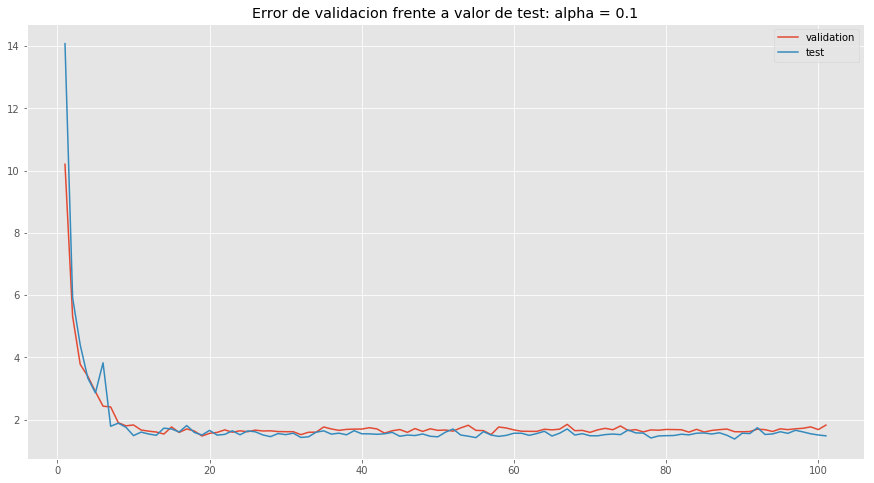

In [23]:
plt.figure(figsize=(15,8))
plt.title("Error de validacion frente a valor de test: alpha = 0.1")

plt.plot(cv_results_capa_3_fino['param_hidden_layer_sizes'].str[0].loc[cv_results_capa_3_fino['param_alpha'] == 0.1] ,1 - cv_results_capa_3_fino['mean_test_score'].loc[cv_results_capa_3_fino['param_alpha'] == 0.1], label='validation')
plt.plot(test_results['param_hidden_layer_sizes'].str[0].loc[test_results['param_alpha'] == 0.1] ,1 - test_results['mean_test_score'].loc[test_results['param_alpha'] == 0.1], label='test')

plt.legend(loc='upper right')
plt.show()